In [1]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
df = pd.read_csv(r"C:\Users\gabri\Documents\ULaval\DESS - Intelligence artificielle\Automne 2022\GIF-7005 Introduction à l'apprentissage automatique\Projet\sigir_train_full.txt", sep=",", header=0)

In [2]:
def construct_session_sequences(df, sessionID, itemID):
    """
    Fonction qui construit une liste de séquence d'items pour chacune 
    des sessions du jeu de données.

    Args:
        df: Un dataframe constitué des données déjà pré-traitées.
        sessionID: Le ID d'une Session d'un utilisateur.
        itemID: Le ID d'un item.

    Returns:
        Une liste contenant tous les items groupés par session. 
    """
    session_groups = df.groupby([sessionID])
    session_seq = []
    for name, group in session_groups:
        session_seq.append(list(group[itemID].values))

    return session_seq

sessions = construct_session_sequences(df, 'SessionId', 'ItemId')

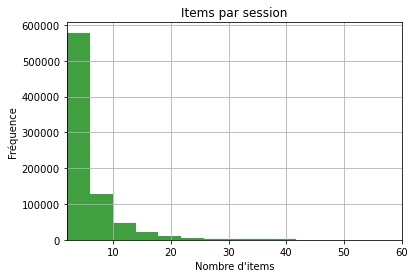

In [3]:
# Histogramme des sessions
# L’histogramme suivant illustre le nombre d’items par session.
# On retrouve 801744 sessions. 
count_list_session = []
for s in sessions:
    count_list_session.append(len(s))
    
n, bins, patches = plt.hist(count_list_session, 25, facecolor='g', alpha=0.75)
plt.xlabel("Nombre d'items")
plt.ylabel("Fréquence")
plt.title('Items par session')
plt.xlim(2, 60)
plt.grid(True)
plt.show()

In [4]:
print("Nombre moyen d'items par session:", np.mean(count_list_session))
print("Nombre minimal d'items par session:", np.min(count_list_session))
print("Nombre maximal d'items par session:", np.max(count_list_session))
print("Nombre total de sessions:", len(sessions))

Nombre moyen d'items par session: 5.265633419146261
Nombre minimal d'items par session: 2
Nombre maximal d'items par session: 101
Nombre total de sessions: 801744


In [5]:
# Entraînement :
# D’abord, on construit le fichier d’entraînement en ne préservant que les n-1 items 
# d’une séquence pour une session de n items. 

# Exemple: Pour la session 0, on a les items [1567, 26843, 11503].
# Ainsi, pour cette même session, on aura dans le fichier d'entraînement les items [1567, 26843]
train_X = []
for s in sessions:
    train_X.append(s[:-1])

# Validation
# Ensuite, on construit les fichiers de test et de validation comportant des séquences 
# constituées des items n-1 et n. Par la suite, on utilise l’item n-1 afin de générer 
# les prédictions du prochain item et ainsi vérifier si l’item n est inclus dans les prédictions. 
# Les données présentes dans le fichier de validation ne sont pas dans le fichier de test.

# Exemple: Pour la session 0, on a les items [1567, 26843, 11503].
# Ainsi, pour cette même session, on aura dans les fichiers de validation/test les items [26843, 11503]
validation = []
for s in sessions:
    validation.append(s[-2:])
    
# On génère des indexs aléatoires en validation et test    
size_vect = round(0.20 * len(sessions))
index = np.random.choice(range(len(validation)), size_vect * 2, replace=False)    

valid_X = np.array(validation)[index[:size_vect]].tolist()
test_X = np.array(validation)[index[size_vect:]].tolist()

In [6]:
# Dictionnaire contenant les hyperparamètres choisis pour 
# entraîner le modèle Word2vec
hyperparameters = {"vector_size" : 100, 
                   "min_count" : 1,
                   "epochs" : 5,
                   "workers" : 10,
                   "sg" : 1
                  }

def training_model_word2vec(data, params : dict):
    """
    Fonction entraînant un modèle Word2vec.
    On peut imaginer une session comme une phrase et les items 
    comme les mots de cette phrase. On créé le vocabulaire (ensemble du corpus) 
    à partir de toutes les données d’entraînement. Le modèle Word2vec se sert 
    de ce corpus pour apprendre les relations entre les items d’une session.

    Un modèle word2vec est un modèle de réseau de neurones simple comportant 
    qu’une seule couche cachée. À partir du fichier d’entraînement, on prend en 
    entrée un mot, et essaie de prédire le contexte des mots qui l’entourent 
    comme sortie. Dans notre cas, on utilise l’architecture CBOW 
    (Continuous Bag of Words)  pour construire notre modèle.

    Args:
        data: Une liste des sessions provenant du fichier d'entraînement.
        params: Un dictionnaire constitué des hyperparamètres utilisés.

    Returns:
        Le modèle entraîné.
    """
    model = Word2Vec(**params)
    model.build_vocab(data)
    model.train(data, 
                total_examples = model.corpus_count, 
                epochs = model.epochs, 
                compute_loss = True)
    
    return model

model = training_model_word2vec(train_X, params = hyperparameters)

In [8]:
def produce_list_topK(item, K):
    """
    Fonction produisant une liste de top K de meilleurs items
    suggérés. À partir de la méthode predict_output_word() appliquée 
    au modèle, on vient extraire les K meilleurs éléments. 

    Args:
        item: Le n-1 item provenant du fichier de validation.
        K: Nombre d'items suggérés

    Returns:
        Une liste constituée des K meilleurs items suggérés pour
        le n-1-ème item du fichier de validation ou de test
    """
    list_topK = []
    for item in model.predict_output_word([item], topn=K):
        list_topK.append(item[0])
    return list_topK

def calculing_mrr(dataset):
    """
    Fonction mesurant la performance du modèle en calculant 
    le mean reciprocal rank (MRR). 
    
    Exemple: 
    Supposons que l’on ait une session comportant les items 
    suivants : [???, 10255, 5104] 
    On aurait donc une séquence d’items dans le fichier d’entraînement 
    telle que : [???, 10255] 
    On aurait donc une séquence d’items dans le fichier de validation 
    telle que : [10255, 5104] 

    On détermine le top k des éléments suggérés en prenant l’item n-1 (10255) 
    du fichier de validation. Ensuite, on vérifie si le dernier item (5104) 
    est présent dans le top K.  S’il est présent, on note son rang. 
    Dans cet exemple, le top 5 est [10255, 5104, 11035, 11726, 26443].    
    Puisque l’élément en question est en deuxième position, alors 
    on lui attribut un rang de 2. On procède de la sorte pour toutes les 
    sessions des fichiers de validation ou de test. 
    
    Formule du MRR: MRR = 1/𝑄 ∑(𝑖 = 1 à 𝑄) 1/rangi où Q est le nombre total de
    sessions.

    Args:
        dataset: Une liste de sessions des fichiers de validation et de test

    Returns:
        Un float. La mesure du mean reciprocal rank (MRR).
    """
    sum_rank_5 = 0
    sum_rank_10 = 0
    sum_rank_20 = 0
    for i in dataset:      
        if i[1] in produce_list_topK(i[0], K=5):
            sum_rank_5 += (1 / (produce_list_topK(i[0], K=5).index(i[1])+1)) 
        if i[1] in produce_list_topK(i[0], K=10):
            sum_rank_10 += (1 / (produce_list_topK(i[0], K=10).index(i[1])+1)) 
        if i[1] in produce_list_topK(i[0], K=20):
            sum_rank_20 += (1 / (produce_list_topK(i[0], K=20).index(i[1])+1)) 
            
    MRR5 = sum_rank_5 / len(dataset)  
    MRR10 = sum_rank_10 / len(dataset)   
    MRR20 = sum_rank_20 / len(dataset) 

    return print('MRR K=5 :', MRR5, ' | ', 'MRR K=10 :', MRR10, ' | ', 'MRR K=20 :', MRR20)



def calculing_HitRate(dataset):
    """
    Fonction mesurant la performance du modèle en calculant 
    le taux de succès (hit rate). 
    
    Exemple: 
    Supposons que l’on ait une session comportant les items 
    suivants : [???, 10255, 5104] 
    On aurait donc une séquence d’items dans le fichier d’entraînement 
    telle que : [???, 10255] 
    On aurait donc une séquence d’items dans le fichier de validation 
    telle que : [10255, 5104] 

    On détermine le top k des éléments suggérés en prenant l’item n-1 (10255) 
    du fichier de validation. Ensuite, on vérifie si le dernier item (5104) 
    est présent dans le top K.  S’il est présent, on attribut 1 à une variable
    indicatrice et 0 sinon. Dans cet exemple, le top 5 est [10255, 5104, 11035, 11726, 26443].    
    Puisque l’élément en question y est présent, alors on lui attribut la valeur de 1. 
    On procède de la sorte pour toutes les sessions des fichiers de validation et de test.  
    
    Formule du hit rate: HR = 1/Q ∑(𝑖 = 1 à k) (I(element i ∊ top k)) où Q est le nombre total 
    de sessions.

    Args:
        dataset: Une liste de sessions des fichiers de validation ou de test

    Returns:
        Un float. La mesure du taux de succès (hit rate).
    """
    sum_hr_1 = 0
    sum_hr_3 = 0
    sum_hr_5 = 0
    for i in dataset:      
        if i[1] in produce_list_topK(i[0], K=1):
            sum_hr_1 += 1 
        if i[1] in produce_list_topK(i[0], K=3):
            sum_hr_3 += 1
        if i[1] in produce_list_topK(i[0], K=5):
            sum_hr_5 += 1
            
    HR1 = sum_hr_1 / len(dataset)   
    HR3 = sum_hr_3 / len(dataset) 
    HR5 = sum_hr_5 / len(dataset)

    return print('Hit Rate K=1 :', HR1, ' | ', 'Hit Rate K=3 :', HR3, ' | ', 'Hit Rate K=5 :', HR5)

In [67]:
# Calcul du MRR top 10 et top 20 sur les données de validation
calculing_mrr(valid_X)

MRR K=5 : 0.2689538652148372  |  MRR K=10 : 0.2798880086659946  |  MRR K=20 : 0.285067637537623


In [68]:
# Calcul du MRR top 10 et top 20 sur les données de test
calculing_mrr(test_X)

MRR K=5 : 0.2684391545940453  |  MRR K=10 : 0.27932045695562474  |  MRR K=20 : 0.2845174074684096


In [17]:
# Calcul du taux de succès (hit rate) top 1 et top 3 sur les données de validation
calculing_HitRate(valid_X)

Hit Rate K=1 : 0.1761158473080593  |  Hit Rate K=3 : 0.3455150951985981  |  Hit Rate K=5 : 0.42750500470847963


In [22]:
# Calcul du taux de succès (hit rate) top 1 et top 3 sur les données de test
calculing_HitRate(test_X)

Hit Rate K=1 : 0.1783983685585816  |  Hit Rate K=3 : 0.34666259222071855  |  Hit Rate K=5 : 0.4308664226156696


C:\Users\gabri\AppData\Local\Temp/ipykernel_812/2151413819.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


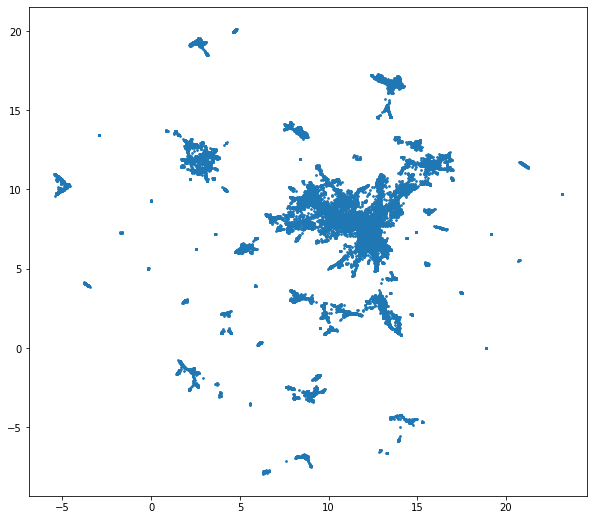

In [8]:
model.init_sims(replace=True)
X = model.wv[model.wv.key_to_index]
cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')